In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn._config import set_config
set_config(print_changed_only=False)

## 1. Load Data

In [2]:
import pandas as pd

feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index','column_name'])

feature_name_df.head(3)

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z


In [3]:
feature_name_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   column_index  561 non-null    int64 
 1   column_name   561 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.9+ KB


In [4]:
feature_name_df_group = feature_name_df.groupby(['column_name']).count()
feature_name_df_group

,column_index
column_name,
"angle(X,gravityMean)",1
"angle(Y,gravityMean)",1
"angle(Z,gravityMean)",1
"angle(tBodyAccJerkMean),gravityMean)",1
"angle(tBodyAccMean,gravity)",1
...,...
tGravityAccMag-max(),1
tGravityAccMag-mean(),1
tGravityAccMag-min(),1


In [5]:
feature_name_df_group[ feature_name_df_group['column_index'] > 1 ].head(3)

,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3


In [6]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] >0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [7]:
new_feature_name_df = get_new_feature_name_df(feature_name_df)
feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
train_X = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
test_X = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
train_y = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
test_y = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])

train_X.shape, test_X.shape, train_y.shape, test_y.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

## 2. DecisionTreeClassifier

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(train_X , train_y)

pred = dt_clf.predict(test_X)
accuracy = accuracy_score(test_y , pred)

print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8622
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


## 3. GridSearchCV

In [9]:
from sklearn.model_selection import GridSearchCV

# params = {'max_depth' : [6, 8, 10, 12, 16 ,20, 24]}
params = {'max_depth' : [6, 8, 10, 12, 16]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(train_X, train_y)

print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
GridSearchCV 최고 평균 정확도 수치:0.8479
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8}


In [10]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.846303
1,8,0.847941
2,10,0.840464
3,12,0.843319
4,16,0.845358


In [11]:
for depth in params['max_depth']:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=42)
    dt_clf.fit(train_X, train_y)
    
    pred = dt_clf.predict(test_X)
    accuracy = accuracy_score(test_y, pred)

    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8548
max_depth = 8 정확도: 0.8711
max_depth = 10 정확도: 0.8677
max_depth = 12 정확도: 0.8616
max_depth = 16 정확도: 0.8619


In [12]:
params = {
    # 'max_depth' : [8, 12, 16, 20],
    'max_depth' : [8, 12, 16],
    'min_samples_split' : [16, 24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(train_X, train_y)

print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearchCV 최고 평균 정확도 수치: 0.8509
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 24}


In [13]:
best_df_clf = grid_cv.best_estimator_

pred = best_df_clf.predict(test_X)

accuracy = accuracy_score(test_y, pred)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8687


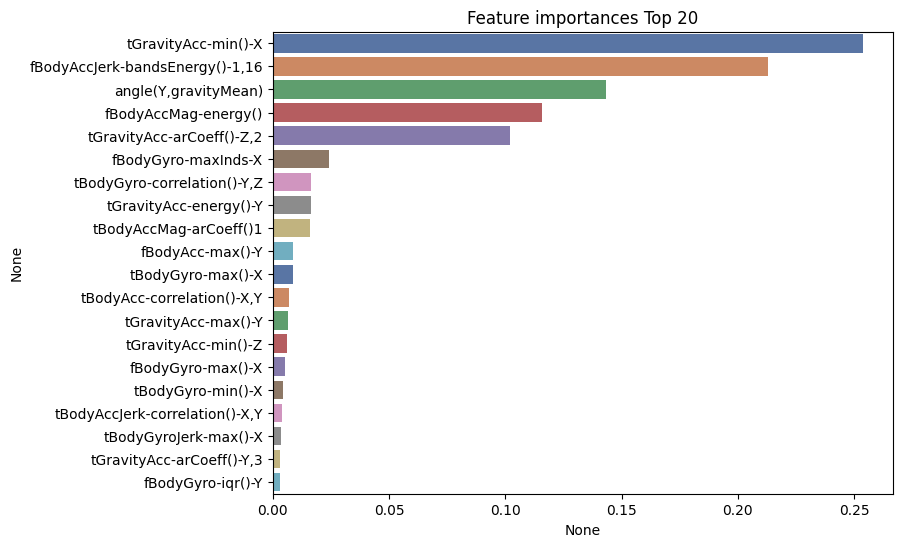

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_

ftr_importances = pd.Series(ftr_importances_values, index=train_X.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
palette = sns.color_palette('deep', 20)
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y=ftr_top20.index, palette=palette)
plt.show()